# Auto Feature Selection
- What model combinations can be used to find the ideal features to model a time series with and also to make the best forecasts?  
- See [Auto Model Specification with ML Techniques for Time Series](https://towardsdatascience.com/auto-model-specification-with-ml-techniques-for-time-series-e7b9a90ae9d7)  

In [1]:
import pandas as pd
import numpy as np
from scalecast.Forecaster import Forecaster
from scalecast.util import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

Diagram to demonstrate the [auto_Xvar_select()](https://scalecast.readthedocs.io/en/latest/Forecaster/Forecaster.html#src.scalecast.Forecaster.Forecaster.auto_Xvar_select) method:


![](./diagram.jpg)

## Use 50 Random Series from M4 Hourly

In [2]:
models = (
    'mlr',
    'elasticnet',
    'gbt',
    'knn',
    'svr',
    'mlp',
)

Hourly = pd.read_csv(
    'Hourly-train.csv',
    index_col=0,
).sample(50)

Hourly_test = pd.read_csv(
    'Hourly-test.csv',
    index_col=0,
)
Hourly_test = Hourly_test.loc[Hourly.index]

info = pd.read_csv(
    'M4-info.csv',
    index_col=0,
    parse_dates=['StartingDate'],
    dayfirst=True,
)

results = pd.DataFrame(
    index = models,
    columns = models,
).fillna(0)

## Run all Model Combos and Evaluate SMAPE

In [3]:
for i in tqdm(Hourly.index):
    y = Hourly.loc[i].dropna()
    sd = info.loc[i,'StartingDate']
    fcst_horizon = info.loc[i,'Horizon']
    cd = pd.date_range(
        start = sd,
        freq = 'H',
        periods = len(y),
    )
    f = Forecaster(
        y = y,
        current_dates = cd,
        future_dates = fcst_horizon,
    )
    f.set_test_length(fcst_horizon)
    f.integrate(critical_pval=.99)
    for xvm in models:
        for fcstm in models:
            f2 = f.deepcopy()
            f2.auto_Xvar_select(
                estimator = xvm,
                monitor='LevelTestSetMAE',
                max_ar = 48,
                exclude_seasonalities = ['quarter','month','week','day'],
            )
            f2.set_estimator(fcstm)
            f2.proba_forecast(dynamic_testing=False) if fcstm in (
                'mlp','gbt','xgboost','lightgbm','rf'
            ) else f2.manual_forecast(dynamic_testing=False)
            point_fcst = f2.export('lvl_fcsts')[fcstm]
            results.loc[xvm,fcstm] += metrics.smape(
                Hourly_test.loc[i].dropna().to_list(),
                point_fcst.to_list(),
            )

  0%|          | 0/50 [00:00<?, ?it/s]

## View Results

### SMAPE Combos

In [4]:
results = results / 50
results

,mlr,elasticnet,gbt,knn,svr,mlp
mlr,0.111073,0.226051,0.094856,0.080180,0.151116,0.683574
elasticnet,0.108093,0.202424,0.087273,0.077058,0.149023,0.579447
gbt,0.122764,0.234555,0.091155,0.087964,0.151497,0.754234
knn,0.117055,0.236518,0.093299,0.087740,0.156540,0.759222
svr,0.115661,0.238800,0.087620,0.107821,0.140633,0.786281
mlp,0.116515,0.215392,0.080034,0.075500,0.145879,0.601938


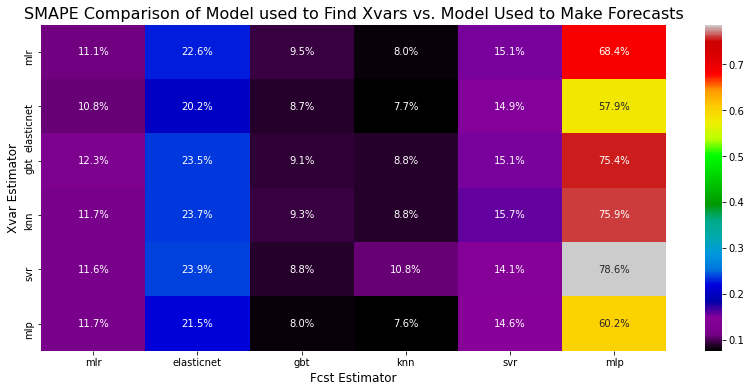

In [35]:
fig, ax = plt.subplots(figsize=(14,6))
sns.heatmap(results,cmap='nipy_spectral',ax=ax,annot=True,fmt='.1%')
plt.ylabel('Xvar Estimator',size=12)
plt.xlabel('Fcst Estimator',size=12)
plt.title('SMAPE Comparison of Model used to Find Xvars vs. Model Used to Make Forecasts',size=16)
plt.show()

### Best Models at Making Forecasts on Average

In [6]:
# Fcst estimators
results.mean().sort_values()

knn           0.086044
gbt           0.089039
mlr           0.115193
svr           0.149115
elasticnet    0.225623
mlp           0.694116
dtype: float64

### Best Models at Finding Xvars on Average

In [7]:
# Xvar estimators
results.mean(axis=1).sort_values()

elasticnet    0.200553
mlp           0.205876
mlr           0.224475
gbt           0.240362
knn           0.241729
svr           0.246136
dtype: float64